In [ ]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import UNKNOWN_CLASS_ID
from ultralytics import YOLO

from experiment.prediction_utils import (
    calculate_metrics,
    create_confusion_matrix,
    evaluate_predictions,
    render_confusion_matrix,
    update_confusion_matrix,
)
from experiment.settings import (
    CLASS_ID_TO_NAME,
    FINAL_PREDICTIONS_PATH,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    LABELING_REC_DIFF_BACKGROUND_ID,
    LABELING_REC_SAME_BACKGROUND_ID,
    OBJECT_DATASETS_PATH,
    TRAINING_DATASETS_PATH,
    YOLO_MODELS_PATH,
    SIMROOM_ID,
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service

%matplotlib inline

In [2]:
model = YOLO("yolo11n-cls.pt")

# Create Training Data



In [3]:
def save_roi(roi: np.ndarray, out_dir: Path, file_idx: int, class_id: str):
    """
    Save an ROI crop in <out_dir>/<class_id>/<file>.png
    """
    class_dir = out_dir / class_id  # one subdir per class
    class_dir.mkdir(parents=True, exist_ok=True)

    filename = f"{file_idx:06d}_{class_id}.png"
    cv2.imwrite(str(class_dir / filename), roi)


def create_dataset(
    session: Session,
    calibration_id: int,
    tracked_classes: list[SimRoomClassDTO],
    dataset_path: Path,
) -> None:
    """
    Creates a balanced 90 %/10 % train/val split with no padding.

    Resulting structure:
        dataset_path/
          train/
            <class_id>/*.png
          val/
            <class_id>/*.png
    """
    # start fresh
    if dataset_path.exists():
        shutil.rmtree(dataset_path)

    train_root = dataset_path / "train"
    val_root = dataset_path / "val"
    train_root.mkdir(parents=True, exist_ok=True)
    val_root.mkdir(parents=True, exist_ok=True)

    # -------------------------------------------------------------
    # 1. Collect ROIs per class
    # -------------------------------------------------------------
    rois_per_class: dict[str, list[np.ndarray]] = {}
    for tracked_class in tracked_classes:
        result_paths = simrooms_repo.get_tracking_result_paths(
            session, calibration_id, tracked_class.id
        )

        cid = str(tracked_class.id)
        rois_per_class.setdefault(cid, [])
        for npz_path in result_paths:
            roi = np.load(npz_path)["roi"]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            rois_per_class[cid].append(roi)

    # drop empty classes
    rois_per_class = {c: r for c, r in rois_per_class.items() if r}
    if not rois_per_class:
        raise ValueError("No class contains any ROI images.")

    # -------------------------------------------------------------
    # 2. Balance by the smallest class size
    # -------------------------------------------------------------
    min_samples = min(len(r) for r in rois_per_class.values())
    rng = np.random.default_rng(seed=42)

    # -------------------------------------------------------------
    # 3. Split and save
    # -------------------------------------------------------------
    global_idx = 0
    for cid, rois in rois_per_class.items():
        idxs = rng.choice(len(rois), size=min_samples, replace=False)
        selected = [rois[i] for i in idxs]

        split = int(0.9 * min_samples)
        train_split, val_split = selected[:split], selected[split:]

        for roi in train_split:
            save_roi(roi, train_root, global_idx, cid)
            global_idx += 1
        for roi in val_split:
            save_roi(roi, val_root, global_idx, cid)
            global_idx += 1

In [4]:
with Session(engine) as session:
    same_background_calibration_id = simrooms_repo.get_calibration_recording(
        db=session, simroom_id=SIMROOM_ID, recording_id=LABELING_REC_SAME_BACKGROUND_ID
    ).id

    diff_background_calibration_id = simrooms_repo.get_calibration_recording(
        db=session, simroom_id=SIMROOM_ID, recording_id=LABELING_REC_DIFF_BACKGROUND_ID
    ).id

    tracked_classes = simrooms_service.get_tracked_classes(
        db=session, calibration_id=same_background_calibration_id
    )

    tracked_classes_same_background = simrooms_service.get_tracked_classes(
        db=session, calibration_id=same_background_calibration_id
    )
    tracked_classes_diff_background = simrooms_service.get_tracked_classes(
        db=session, calibration_id=diff_background_calibration_id
    )

    all_tracked_classes = (
        tracked_classes_same_background + tracked_classes_diff_background
    )

In [5]:
CREATE_DATASETS = False

if CREATE_DATASETS:
    create_dataset(
        session,
        same_background_calibration_id,
        tracked_classes_same_background,
        TRAINING_DATASETS_PATH / "same_background",
    )
    # create_dataset(tracked_classes_diff_background, TRAINING_DATASETS_PATH / "diff_background")
    # create_dataset(all_tracked_classes, TRAINING_DATASETS_PATH / "combined_background")

# Train Models

In [6]:
class_ids = [str(anno.id) for anno in tracked_classes_same_background]
results = model.train(
    data=TRAINING_DATASETS_PATH / "same_background",
    epochs=100,
    imgsz=224,
    device="cuda",
    batch=128,
)

New https://pypi.org/project/ultralytics/8.3.137 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/training_datasets/same_background, epochs=100, time=None, patience=100, batch=128, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

E0000 00:00:1747421408.337990    2465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747421408.351898    2465 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train... 8541 images, 204 corrupt: 100%|██████████| 8541/8541 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train/1/000122_1.png: ignoring corrupt image/label: image size (42, 9) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train/11/006498_11.png: ignoring corrupt image/label: image size (7, 30) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train/11/006558_11.png: ignoring corrupt image/label: image size (8, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train/11/006568_11.png: ignoring corrupt image/label: image size (9, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train/11/006575_11.png: ignoring corrupt image/label: image size (9, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experime


val: Scanning /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val... 961 images, 14 corrupt: 100%|██████████| 961/961 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val/11/007066_11.png: ignoring corrupt image/label: image size (9, 28) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val/11/007069_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val/11/007108_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val/11/007114_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val/11/007122_11.png: ignoring corrupt image/label: image size (7, 28) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiment/data/training_dat

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.001), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to /home/zilian/projects/bachelorproef/runs/classify/train12
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.62G       1.84         93        224: 100%|██████████| 67/67 [00:05<00:00, 12.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 20.36it/s]


                   all      0.924      0.991

      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.63G     0.2626         93        224: 100%|██████████| 67/67 [00:05<00:00, 13.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.32it/s]

                   all      0.949      0.993



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.61G     0.1265         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.70it/s]

                   all      0.725      0.875



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.61G    0.09243         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.35it/s]

                   all      0.863      0.975



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.61G    0.08003         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.03it/s]

                   all      0.958      0.998



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.61G    0.06166         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.13it/s]

                   all      0.977      0.996



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.61G    0.05724         93        224: 100%|██████████| 67/67 [00:03<00:00, 20.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.84it/s]

                   all      0.929      0.995



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.61G    0.04906         93        224: 100%|██████████| 67/67 [00:03<00:00, 20.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.63it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.61G    0.03756         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 56.37it/s]

                   all      0.869      0.971



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.61G    0.03602         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.86it/s]

                   all      0.931      0.999



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.61G    0.03339         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.13it/s]

                   all       0.98      0.998



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.61G    0.04129         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]

                   all      0.829      0.975



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.61G    0.04127         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.07it/s]

                   all      0.956      0.999



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.61G    0.03956         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.44it/s]

                   all      0.923      0.981



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.61G    0.03486         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.71it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.61G    0.02834         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.48it/s]

                   all      0.991      0.999



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.61G    0.02208         93        224: 100%|██████████| 67/67 [00:03<00:00, 20.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.96it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.61G    0.02289         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.11it/s]

                   all      0.793      0.972



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.61G    0.03336         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.51it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.61G    0.03219         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.80it/s]

                   all       0.89       0.98



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.61G    0.02624         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.52it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.61G    0.02038         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.47it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.61G    0.01729         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.33it/s]


                   all       0.99          1

      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.61G    0.02066         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.52it/s]

                   all      0.994      0.999



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.61G    0.01726         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.79it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.61G    0.02051         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.62it/s]

                   all      0.994      0.998



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.61G    0.01656         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.91it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.61G     0.0288         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.27it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.61G    0.02317         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.98it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.61G    0.01899         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.11it/s]

                   all      0.733      0.924



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.61G    0.01789         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.30it/s]

                   all      0.981      0.998



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.61G    0.01967         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 58.00it/s]

                   all      0.992      0.999



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.61G    0.01855         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.05it/s]

                   all      0.975      0.997



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.61G    0.01932         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.96it/s]

                   all      0.913      0.996



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.61G    0.01488         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 56.50it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.61G    0.01585         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.57it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.61G    0.01745         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.47it/s]


                   all      0.996          1

      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.61G    0.01341         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.60it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.61G     0.0115         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.18it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.61G    0.01185         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.61G    0.01575         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.35it/s]

                   all      0.971      0.996



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.61G    0.01202         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.17it/s]

                   all      0.998      0.999



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.61G    0.01069         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.21it/s]

                   all       0.88       0.99



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.61G    0.01276         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.49it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.61G    0.01307         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.87it/s]

                   all       0.98      0.999



      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.61G    0.01233         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.38it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.61G    0.01147         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.52it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.61G    0.01104         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.46it/s]

                   all      0.972      0.997



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.61G    0.01206         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.94it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.61G    0.01117         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.70it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.61G    0.01013         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.87it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.61G    0.01107         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.15it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.61G    0.00719         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.59it/s]

                   all      0.993      0.999



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.61G   0.005247         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.68it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.61G   0.006721         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 57.14it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.61G    0.01031         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.80it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.61G   0.009858         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.48it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      1.61G   0.006848         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.08it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      1.61G   0.009373         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.26it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100      1.61G    0.01164         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.99it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100      1.61G   0.007929         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.46it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100      1.61G   0.005649         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.67it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100      1.61G   0.008556         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.79it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100      1.61G   0.007769         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.73it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100      1.61G   0.005779         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.12it/s]


                   all      0.998          1

      Epoch    GPU_mem       loss  Instances       Size


     66/100      1.61G   0.006395         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.67it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100      1.61G   0.003299         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 56.38it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100      1.61G   0.008194         93        224: 100%|██████████| 67/67 [00:04<00:00, 15.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.22it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100      1.61G   0.004511         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.56it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100      1.61G   0.002419         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.55it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100      1.61G   0.003675         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.81it/s]

                   all      0.978      0.998



      Epoch    GPU_mem       loss  Instances       Size


     72/100      1.61G   0.005758         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.40it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100      1.61G   0.005506         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.06it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      1.61G   0.004228         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.99it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100      1.61G   0.002742         93        224: 100%|██████████| 67/67 [00:03<00:00, 17.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.56it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100      1.61G   0.003662         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.26it/s]


                   all      0.998          1

      Epoch    GPU_mem       loss  Instances       Size


     77/100      1.61G   0.004125         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.79it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100      1.61G   0.005024         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.68it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100      1.61G   0.004003         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.56it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100      1.61G   0.002873         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.62it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100      1.61G   0.003805         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.08it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100      1.61G   0.002803         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.44it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100      1.61G   0.003265         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.45it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100      1.61G   0.004339         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.58it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100      1.61G   0.002223         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.63it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100      1.61G    0.00436         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.46it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100      1.61G   0.003964         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.49it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100      1.61G   0.001965         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100      1.61G   0.002621         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.67it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100      1.61G   0.002215         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.83it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100      1.61G   0.001494         93        224: 100%|██████████| 67/67 [00:04<00:00, 14.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.60it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100      1.61G   0.002226         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.69it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100      1.61G   0.001599         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.07it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100      1.61G   0.002255         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.16it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100      1.61G   0.002166         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.62it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100      1.61G   0.001954         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.61it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100      1.61G  0.0008826         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 56.61it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100      1.61G   0.001017         93        224: 100%|██████████| 67/67 [00:03<00:00, 18.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.53it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100      1.61G   0.001434         93        224: 100%|██████████| 67/67 [00:04<00:00, 16.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.02it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100      1.61G   0.001155         93        224: 100%|██████████| 67/67 [00:03<00:00, 19.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.18it/s]

                   all      0.998          1



100 epochs completed in 0.120 hours.
Optimizer stripped from /home/zilian/projects/bachelorproef/runs/classify/train12/weights/last.pt, 3.2MB
Optimizer stripped from /home/zilian/projects/bachelorproef/runs/classify/train12/weights/best.pt, 3.2MB

Validating /home/zilian/projects/bachelorproef/runs/classify/train12/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n-cls summary (fused): 112 layers, 1,545,239 parameters, 0 gradients, 3.2 GFLOPs
train: /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/train... found 8745 images in 15 classes ✅ 
val: /home/zilian/projects/bachelorproef/experiment/data/training_datasets/same_background/val... found 975 images in 15 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s]


                   all      0.999          1
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/zilian/projects/bachelorproef/runs/classify/train12
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/zilian/projects/bachelorproef/runs/classify/train12


In [22]:
if YOLO_MODELS_PATH.exists():
    shutil.rmtree(YOLO_MODELS_PATH)
YOLO_MODELS_PATH.mkdir(parents=True, exist_ok=True)

model.save(
    str(YOLO_MODELS_PATH / "yolo11n-cls-same-background.pt"),
)

In [23]:
model = YOLO(str(YOLO_MODELS_PATH / "yolo11n-cls-same-background.pt"))

model.names

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '8',
 14: '9'}

# Test Models

In [24]:
GROUND_TRUTH_PATH = Path("data/ground_truth.csv")
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
ground_truth_df.head()

,recording_id,frame_idx,class_id,mask_area,laplacian_variance,x1,y1,x2,y2
0,67b71a70-da64-467a-9fb6-91bc29265fd1,223,1,5437,55.662777,1046,467,1108,567
1,67b71a70-da64-467a-9fb6-91bc29265fd1,42,1,1431,144.979676,645,451,679,498
2,67b71a70-da64-467a-9fb6-91bc29265fd1,86,1,1408,166.952593,665,437,698,485
3,67b71a70-da64-467a-9fb6-91bc29265fd1,242,1,8198,54.435912,902,449,978,572
4,67b71a70-da64-467a-9fb6-91bc29265fd1,21,1,1426,164.828114,642,450,676,497


In [25]:
object_rois_per_recording = {}
object_df_per_recording = {}

for trial_recording_id in FULLY_LABELED_RECORDINGS:
    object_rois = {}

    gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / trial_recording_id
    gaze_segmentation_results = list(gaze_segmentation_results_path.iterdir())
    gaze_segmentation_results.sort(key=lambda x: int(x.stem))
    gaze_segmentation_results = [
        np.load(result, allow_pickle=True) for result in gaze_segmentation_results
    ]

    object_df = pd.read_csv(OBJECT_DATASETS_PATH / f"{trial_recording_id}.csv")
    object_df = object_df.drop(columns=["embedding"])
    viewed_object_ids = object_df["object_id"].unique()
    object_df_per_recording[trial_recording_id] = object_df

    for result in gaze_segmentation_results:
        frame_idx = int(result["frame_idx"])
        for i, object_id in enumerate(result["object_ids"]):
            if object_id not in viewed_object_ids:
                continue

            object_rois[f"{object_id}_{frame_idx}"] = result["rois"][i]

    object_rois_per_recording[trial_recording_id] = object_rois

In [47]:
def fuse_track(object_rows, rois, model, conf_threshold: float):
    """
    Select final class by quality‑weighted fusion, then report
    confidence as the *unweighted* mean probability for that class.
    """
    # 1) model prediction → (N, C) tensor → numpy
    results = model(rois, device="cuda", verbose=False)
    probs = np.stack([r.probs.data.cpu().numpy() for r in results])  # (N, C)

    # 2) quality weights
    mask = object_rows["mask_area"].to_numpy(np.float32)
    det_conf = object_rows["confidence"].to_numpy(np.float32)
    mask_n = mask / mask.max() if mask.max() > 0 else np.ones_like(mask)
    weights = mask_n * det_conf  # (N,)

    if weights.sum() == 0:  # all zeros guard
        weights = np.ones_like(weights)

    # 3) pick class with highest weighted avg prob
    weighted_avg = (weights[:, None] * probs).sum(axis=0) / weights.sum()
    class_id = int(weighted_avg.argmax())

    # 4) track confidence = mean of *original* probs for this class
    track_conf = float(probs[:, class_id].mean())

    # 5) rejection rule
    if track_conf < conf_threshold:
        return UNKNOWN_CLASS_ID, 0.0

    return int(model.names[class_id]), track_conf


def fuse_track_by_majority_vote(object_rows, rois, model, conf_threshold: float):
    """
    Majority‑vote fusion **without frame weighting**.

    Workflow
    --------
    1. Run the model once on all ROI crops → (N_frames, N_classes) soft‑max.
    2. Each frame votes for the class with the highest probability.
    3. The class with the most votes = final class_id.
    4. Track‑level confidence = **mean soft‑max probability of that class
       across all frames** (not the vote share).
    5. If that mean‑prob < conf_threshold → label as UNKNOWN_CLASS_ID.

    Returns
    -------
    (predicted_class_name_or_unknown, confidence)
    """
    # 1) batched inference
    results = model(rois, device="cuda", verbose=False)
    probs = np.stack([r.probs.data.cpu().numpy() for r in results])  # (N, C)

    # 2) per‑frame winner
    frame_preds = probs.argmax(axis=1)  # (N,)

    # 3) majority vote
    counts = np.bincount(frame_preds, minlength=probs.shape[1])
    class_id = int(counts.argmax())

    # 4) confidence = average probability for that class
    avg_prob = float(probs[:, class_id].mean())  # 0‑1

    # 5) rejection rule
    if avg_prob < conf_threshold:
        return UNKNOWN_CLASS_ID, 0.0

    return int(model.names[class_id]), avg_prob


def process_grid_combination(params):
    cm = create_confusion_matrix()

    (conf,) = params

    for trial_recording_id in FULLY_LABELED_RECORDINGS:
        object_rois = object_rois_per_recording[trial_recording_id]
        object_df = object_df_per_recording[trial_recording_id]
        object_ids = object_df["object_id"].unique()

        predictions_df = object_df.copy()
        for object_id in object_ids:
            object_rows = object_df[object_df["object_id"] == object_id]
            rois = [
                object_rois[f"{object_id}_{int(row['frame_idx'])}"]
                for _, row in object_rows.iterrows()
            ]

            cls_id, cls_conf = fuse_track_by_majority_vote(
                object_rows, rois, model, conf_threshold=conf
            )

            # add predicted_class_id and prediction_confidence to object_df based on object_id
            predictions_df.loc[
                object_df["object_id"] == object_id, "predicted_class_id"
            ] = cls_id
            predictions_df.loc[
                object_df["object_id"] == object_id, "prediction_confidence"
            ] = cls_conf

        gt_df = ground_truth_df[
            ground_truth_df["recording_id"] == trial_recording_id
        ].copy()

        predictions_df.to_csv(f"predictions_{trial_recording_id}.csv", index=False)

        evaluation_df = evaluate_predictions(predictions_df, gt_df, iou_threshold=0.5)

        update_confusion_matrix(cm, evaluation_df)

        fp_per_class = {class_id: 0 for class_id in CLASS_ID_TO_NAME.keys()}
        fn_per_class = {class_id: 0 for class_id in CLASS_ID_TO_NAME.keys()}
        for _, row in evaluation_df.iterrows():
            true = row.get("true_class_id")
            pred = row.get("predicted_class_id")

            if pd.isna(true) and pred != UNKNOWN_CLASS_ID:
                # A missing true class indicates a false positive
                fp_per_class[pred] += 1

            if pd.isna(pred):
                # A missing predicted class indicates a false negative
                fn_per_class[true] += 1

    metrics = calculate_metrics(cm)
    return params, cm, metrics, fp_per_class, fn_per_class

In [49]:
conf_values = [0.5]  # , 0.6, 0.7, 0.8, 0.9]

total_possibilities = len(conf_values)
num_possibilities_tried = 0

params_list = list(itertools.product(conf_values))
total_possibilities = len(params_list)

print(f"Processing {total_possibilities} possibilities using multiprocessing...")

grid_search_results = {}
for params in params_list:
    num_possibilities_tried += 1
    print(f"Processing possibility {num_possibilities_tried}/{total_possibilities}...")

    params, cm, metrics, fp_per_class, fn_per_class = process_grid_combination(params)

    result = {
        "cm": cm,
        "metrics": metrics,
        "fp_per_class": fp_per_class,
        "fn_per_class": fn_per_class,
    }
    grid_search_results[params] = result

print("All done!")

Processing 1 possibilities using multiprocessing...
Processing possibility 1/1...
All done!


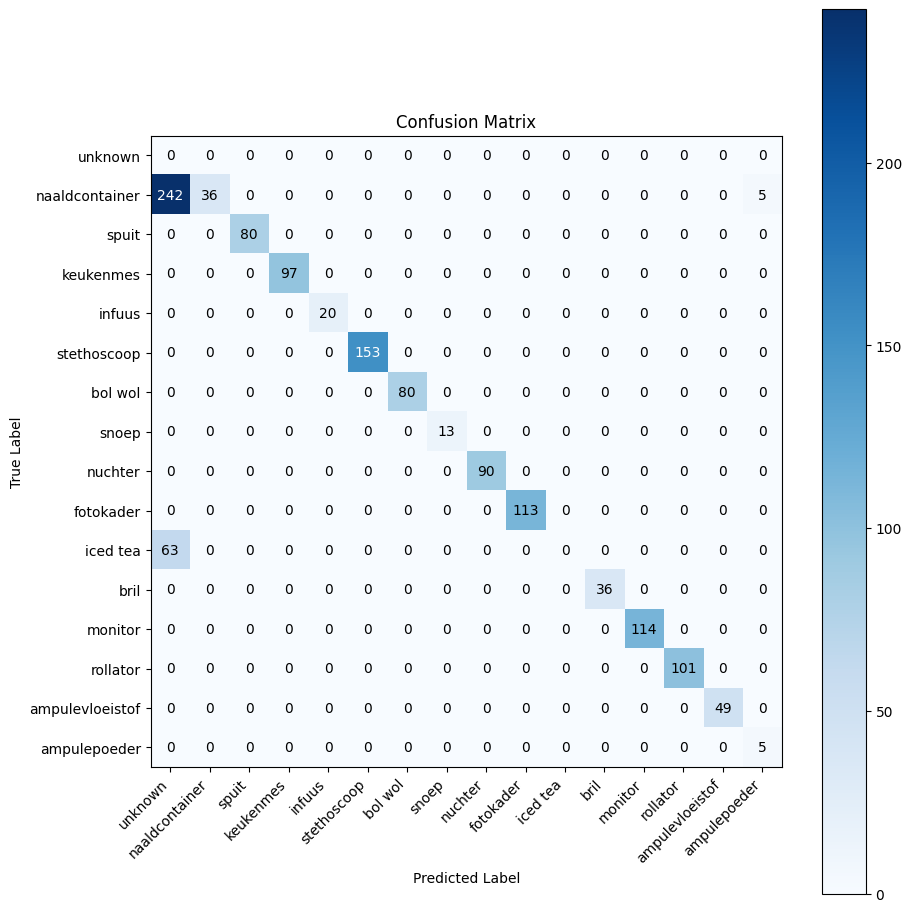

Best grid key: (0.5,)


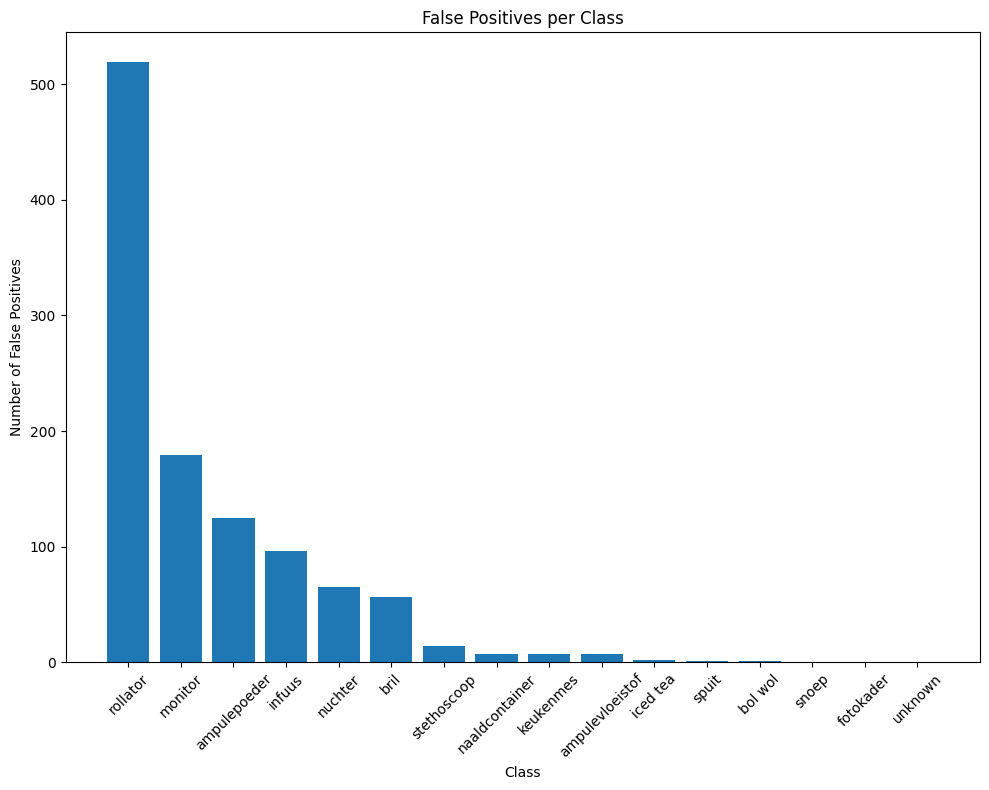

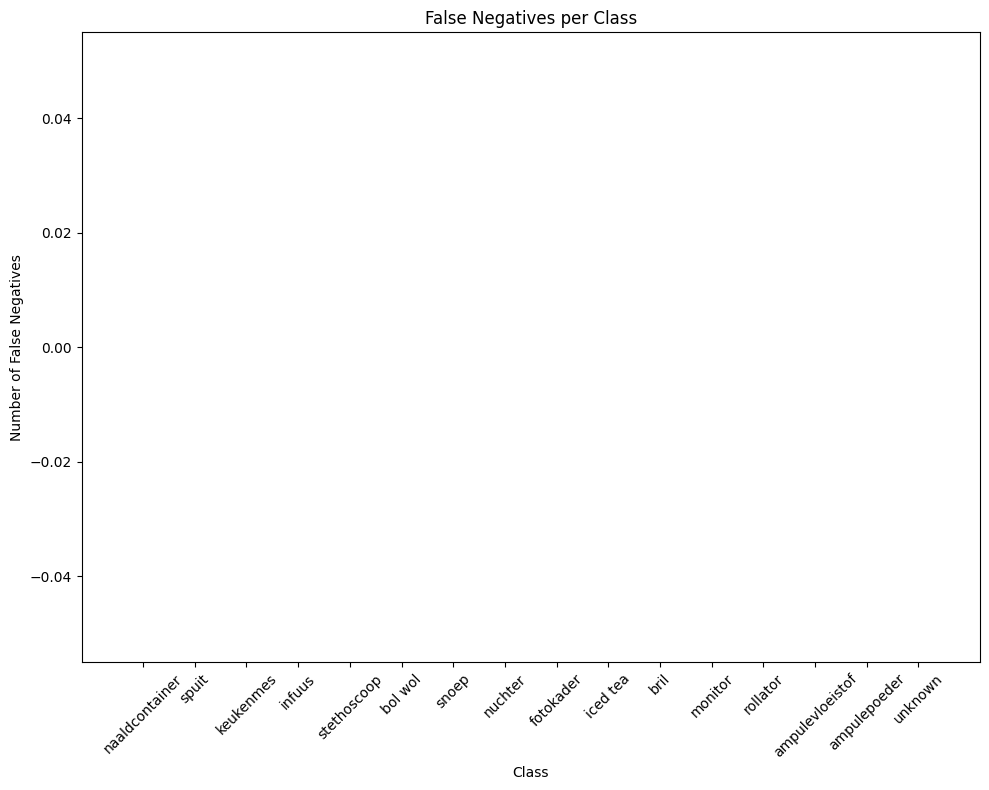

In [50]:
# Select the grid key with the highest overall F1 score.
max_f1 = -1
best_key = None
for key, result in grid_search_results.items():
    f1 = result["metrics"]["micro"]["f1"]
    if f1 > max_f1:
        max_f1 = f1
        best_key = key

best_metrics = grid_search_results[best_key]["metrics"]
best_confusion_matrix = grid_search_results[best_key]["cm"]

# Display confusion matrix
render_confusion_matrix(best_confusion_matrix)
print(f"Best grid key: {best_key}")


# Render false positives per class using matplotlib
def render_per_class_metrics(fp_per_class: dict[str, int], title: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel(ylabel)

    # Sort pairs by descending count
    pairs = sorted(fp_per_class.items(), key=lambda x: x[1], reverse=True)
    class_ids = [int(p[0]) for p in pairs]
    counts = [p[1] for p in pairs]
    labels = [CLASS_ID_TO_NAME.get(cid, f"Unknown {cid}") for cid in class_ids]

    indices = range(len(pairs))  # bar positions

    ax.bar(indices, counts)
    ax.set_xticks(indices)
    ax.set_xticklabels(labels, rotation=45)

    plt.tight_layout()
    plt.show()


render_per_class_metrics(
    grid_search_results[best_key]["fp_per_class"],
    title="False Positives per Class",
    ylabel="Number of False Positives",
)

render_per_class_metrics(
    grid_search_results[best_key]["fn_per_class"],
    title="False Negatives per Class",
    ylabel="Number of False Negatives",
)

In [14]:
import matplotlib.lines as mlines

# Definieer de grid parameters en de metrics die je wilt plotten.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metrics = ["precision", "recall", "f1", "unknown_rate"]

# Loop over elke class in de DataFrame.
for class_id in per_class_metrics_df["class_id"].unique():
    # Filter de DataFrame voor de huidige class.
    df_class = per_class_metrics_df[per_class_metrics_df["class_id"] == class_id]

    # Maak een figuur met horizontaal gestapelde subplots (één per grid parameter).
    fig, axes = plt.subplots(
        1, len(grid_params), figsize=(5 * len(grid_params), 4), sharey=True
    )

    # Zorg dat axes altijd een lijst is.
    if len(grid_params) == 1:
        axes = [axes]

    # Per subplot: groepeer op de huidige parameter en plot de lijnen voor elke metric.
    for ax, param in zip(axes, grid_params, strict=False):
        grouped = df_class.groupby(param)[metrics].mean().reset_index()

        for met in metrics:
            ax.plot(grouped[param], grouped[met], marker="o", color=color_mapping[met])

        ax.set_xlabel(param)
        ax.grid(True)
        ax.set_title(f"{CLASS_ID_TO_NAME.get(class_id, class_id)} - {param}")

    axes[0].set_ylabel("Metric waarde")

    # Maak één globale legende met vaste kleuren.
    legend_handles = []
    for met in metrics:
        line = mlines.Line2D(
            [], [], color=color_mapping[met], marker="o", markersize=4, label=met
        )
        legend_handles.append(line)

    fig.legend(
        handles=legend_handles,
        loc="upper center",
        ncol=len(metrics),
        bbox_to_anchor=(0.5, 1.05),
    )
    fig.suptitle(
        f"Metrics vs Parameters for {CLASS_ID_TO_NAME.get(class_id, class_id)}", y=1.12
    )
    plt.tight_layout()
    plt.show()

NameError: name 'per_class_metrics_df' is not defined

In [ ]:
if FINAL_PREDICTIONS_PATH.exists():
    shutil.rmtree(FINAL_PREDICTIONS_PATH)
FINAL_PREDICTIONS_PATH.mkdir(parents=True, exist_ok=True)

for trial_recording_id in FULLY_LABELED_RECORDINGS:
    object_rois = object_rois_per_recording[trial_recording_id]
    object_df = object_df_per_recording[trial_recording_id]
    object_ids = object_df["object_id"].unique()

    predictions_df = object_df.copy()
    for object_id in object_ids:
        object_rows = object_df[object_df["object_id"] == object_id]
        rois = [
            object_rois[f"{object_id}_{int(row['frame_idx'])}"]
            for _, row in object_rows.iterrows()
        ]

        cls_id, cls_conf = fuse_track_by_majority_vote(
            object_rows, rois, model, conf_threshold=0.5
        )

        # add predicted_class_id and prediction_confidence to object_df based on object_id
        predictions_df.loc[object_df["object_id"] == object_id, "predicted_class_id"] = (
            cls_id
        )
        predictions_df.loc[
            object_df["object_id"] == object_id, "prediction_confidence"
        ] = cls_conf

    predictions_df.to_csv(
        FINAL_PREDICTIONS_PATH / f"{trial_recording_id}.csv", index=False
    )